In [42]:
import os
import cv2
import numpy as np
import pandas as pd
from torchvision import transforms
from torch.utils.data import DataLoader, Dataset as TorchDataset
import torch
import torch.nn.functional as F
from torchvision.transforms import Compose
import matplotlib.pyplot as plt

In [43]:
from collections import namedtuple

In [44]:
Label = namedtuple('Label', [
    'name',        # The identifier of this label
    'id',          # An integer ID associated with this label
    'trainId',     # An integer ID for training
    'category',    # The name of the category
    'categoryId',  # The ID of the category
    'hasInstances',# Whether this label distinguishes between instances
    'ignoreInEval',# Whether to ignore pixels with this label during evaluation
    'color'        # The color of this label in RGB
])

In [45]:
labels = [
    Label('unlabeled', 0, 255, 'void', 0, False, True, 255),
    Label('ego vehicle', 1, 255, 'void', 0, False, True, 255),
    Label('rectification border', 2, 255, 'void', 0, False, True, 255),
    Label('out of roi', 3, 255, 'void', 0, False, True, 255),
    Label('static', 4, 255, 'void', 0, False, True, 255),
    Label('dynamic', 5, 255, 'void', 0, False, True, 255),
    Label('ground', 6, 255, 'void', 0, False, True, 255),
    Label('road', 7, 0, 'ground', 1, False, False, 13),
    Label('sidewalk', 8, 1, 'ground', 1, False, False, 26),
    Label('parking', 9, 255, 'ground', 1, False, True, 255),
    Label('rail track', 10, 255, 'ground', 1, False, True, 255),
    Label('building', 11, 2, 'construction', 2, False, False, 39),
    Label('wall', 12, 3, 'construction', 2, False, False, 52),
    Label('fence', 13, 4, 'construction', 2, False, False, 65),
    Label('guard rail', 14, 255, 'construction', 2, False, True, 255),
    Label('bridge', 15, 255, 'construction', 2, False, True, 255),
    Label('tunnel', 16, 255, 'construction', 2, False, True, 255),
    Label('pole', 17, 5, 'object', 3, False, False, 78),
    Label('polegroup', 18, 255, 'object', 3, False, True, 255),
    Label('traffic light', 19, 6, 'object', 3, False, False, 91),
    Label('traffic sign', 20, 7, 'object', 3, False, False, 104),
    Label('vegetation', 21, 8, 'nature', 4, False, False, 117),
    Label('terrain', 22, 9, 'nature', 4, False, False, 130),
    Label('sky', 23, 10, 'sky', 5, False, False, 143),
    Label('person', 24, 11, 'human', 6, True, False, 156),
    Label('rider', 25, 12, 'human', 6, True, False, 169),
    Label('car', 26, 13, 'vehicle', 7, True, False, 182),
    Label('truck', 27, 14, 'vehicle', 7, True, False, 195),
    Label('bus', 28, 15, 'vehicle', 7, True, False, 208),
    Label('caravan', 29, 255, 'vehicle', 7, True, True, 255),
    Label('trailer', 30, 255, 'vehicle', 7, True, True, 255),
    Label('train', 31, 16, 'vehicle', 7, True, False, 221),
    Label('motorcycle', 32, 17, 'vehicle', 7, True, False, 234),
    Label('bicycle', 33, 18, 'vehicle', 7, True, False, 247),
    Label('license plate', 34, 19, 'vehicle', 7, False, True, 260),
]

Read data 

In [46]:
image_dir = 'archive/images/train'
label_dir = 'archive/labels/train'
test_dir = 'archive/images/test'

print("Images Directory:", os.listdir(image_dir))

print("Labels Directory:", os.listdir(label_dir))

print("Test Directory:", os.listdir(test_dir))

Images Directory: ['aachen', 'bochum', 'bremen', 'cologne', 'darmstadt', 'dusseldorf', 'erfurt', 'hamburg', 'hanover', 'jena', 'krefeld', 'monchengladbach', 'strasbourg', 'stuttgart', 'tubingen', 'ulm', 'weimar', 'zurich']
Labels Directory: ['aachen', 'bochum', 'bremen', 'cologne', 'darmstadt', 'dusseldorf', 'erfurt', 'hamburg', 'hanover', 'jena', 'krefeld', 'monchengladbach', 'strasbourg', 'stuttgart', 'tubingen', 'ulm', 'weimar', 'zurich']
Test Directory: ['aachen', 'bochum', 'bremen', 'cologne', 'darmstadt', 'dusseldorf', 'erfurt', 'hamburg', 'hanover', 'jena', 'krefeld', 'monchengladbach', 'strasbourg', 'stuttgart', 'tubingen', 'ulm', 'weimar', 'zurich']


In [47]:
# Function to generate file paths for train dataset
def get_train_file_paths(image_dir, label_dir):
    data = []
    # Iterate through cities in the train images folder
    for city in os.listdir(image_dir):
        city_image_dir = os.path.join(image_dir, city)
        city_label_dir = os.path.join(label_dir, city)
        if os.path.isdir(city_image_dir) and os.path.isdir(city_label_dir):
            for file in os.listdir(city_image_dir):
                if file.endswith('_leftImg8bit.png'):
                    image_path = os.path.join(city_image_dir, file)
                    image_name = file.replace('_leftImg8bit.png', '')
                    image_label_path = os.path.join(city_label_dir, f'{image_name}_gtFine_labelTrainIds.png')
                    image_polygons_path = os.path.join(city_label_dir, f'{image_name}_gtFine_polygons.json')
                    data.append([image_path, image_label_path, image_polygons_path])
    return pd.DataFrame(data, columns=['image_path', 'image_label_path', 'image_polygons_path'])

# Function to generate file paths for test dataset
def get_test_file_paths(test_dir):
    data = []
    # Iterate through cities in the test images folder
    for city in os.listdir(test_dir):
        city_dir = os.path.join(test_dir, city)
        if os.path.isdir(city_dir):
            for file in os.listdir(city_dir):
                if file.endswith('_leftImg8bit.png'):
                    image_path = os.path.join(city_dir, file)
                    data.append([image_path])
    return pd.DataFrame(data, columns=['image_path'])

# Create train and test DataFrames
train_df = get_train_file_paths(image_dir, label_dir)
test_df = get_test_file_paths(test_dir)

In [48]:
train_df

image_path  \
0     archive/images/train\aachen\aachen_000000_0000...   
1     archive/images/train\aachen\aachen_000002_0000...   
2     archive/images/train\aachen\aachen_000003_0000...   
3     archive/images/train\aachen\aachen_000004_0000...   
4     archive/images/train\aachen\aachen_000005_0000...   
...                                                 ...   
2375  archive/images/train\zurich\zurich_000116_0000...   
2376  archive/images/train\zurich\zurich_000117_0000...   
2377  archive/images/train\zurich\zurich_000118_0000...   
2378  archive/images/train\zurich\zurich_000119_0000...   
2379  archive/images/train\zurich\zurich_000121_0000...   

                                       image_label_path  \
0     archive/labels/train\aachen\aachen_000000_0000...   
1     archive/labels/train\aachen\aachen_000002_0000...   
2     archive/labels/train\aachen\aachen_000003_0000...   
3     archive/labels/train\aachen\aachen_000004_0000...   
4     archive/labels/train\aachen\aachen_000005_0000...   
...                                                 ...   
2375  archive/labels/train\zurich\zurich_000116_0000...   
2376  archive/labels/train\zurich\zurich_000117_0000...   
2377  archive/labels/train\zurich\zurich_000118_0000...   
2378  archive/labels/train\zurich\zurich_000119_0000...   
2379  archive/labels/train\zurich\zurich_000121_0000...   

                                    image_polygons_path  
0     archive/labels/train\aachen\aachen_000000_0000...  
1     archive/labels/train\aachen\aachen_000002_0000...  
2     archive/labels/train\aachen\aachen_000003_0000...  
3     archive/labels/train\aachen\aachen_000004_0000...  
4     archive/labels/train\aachen\aachen_000005_0000...  
...                                                 ...  
2375  archive/labels/train\zurich\zurich_000116_0000...  
2376  archive/labels/train\zurich\zurich_000117_0000...  
2377  archive/labels/train\zurich\zurich_000118_0000...  
2378  archive/labels/train\zurich\zurich_000119_0000...  
2379  archive/labels/train\zurich\zurich_000121_0000...  

[2380 rows x 3 columns]

In [49]:

# Define an empty mask with the same height and width as your image
height, width = 1024, 2048  # Adjust to your image size
grayscale_mask = np.zeros((height, width), dtype=np.uint8)

Make a New Mask from polygons, each object has a value in grayscale.

In [50]:
import json


# Define the size of the mask (2048x1024 or based on your image size)
mask_height, mask_width = 1024, 2048

# Label to grayscale mapping (customize according to your classes)
label_to_grayscale = {
    'unlabeled': 255,
    'ego vehicle': 255,
    'rectification border': 255,
    'out of roi': 255,
    'static': 255,
    'dynamic': 255,
    'ground': 255,
    'road': 13,
    'sidewalk': 26,
    'parking': 255,
    'rail track': 255,
    'building': 39,
    'wall': 52,
    'fence': 65,
    'guard rail': 255,
    'bridge': 255,
    'tunnel': 255,
    'pole': 78,
    'polegroup': 255,
    'traffic light': 91,
    'traffic sign': 104,
    'vegetation': 117,
    'terrain': 130,
    'sky': 143,
    'person': 156,
    'rider': 169,
    'car': 182,
    'truck': 195,
    'bus': 208,
    'caravan': 255,
    'trailer': 255,
    'train': 221,
    'motorcycle': 234,
    'bicycle': 247,
    'license plate': 260,
    'ignored': 255
}

# Function to draw polygons on the mask and save it with the same name as the polygon file
def draw_polygons_on_mask(polygon_path, mask_shape, label_mapping):
    # Create an empty mask with zeros (grayscale, 8-bit)
    mask = np.zeros(mask_shape, dtype=np.uint8)
    
    # Read the polygon data from the JSON file
    with open(polygon_path, 'r') as f:
        polygon_data = json.load(f)
    
    # Loop through each polygon object
    for obj in polygon_data['objects']:
        label = obj['label']
        polygon_points = np.array(obj['polygon'], dtype=np.int32)
        
        # Map the label to its corresponding grayscale value (default to 255 if label not in mapping)
        grayscale_value = label_mapping.get(label, 255)
        
        # Draw the polygon on the mask with the grayscale value
        cv2.fillPoly(mask, [polygon_points], grayscale_value)
    
    return mask

# Create a list to store paths to masks
mask_paths = []

# Example usage for your DataFrame (iterating through the rows of train_df)
for idx, row in train_df.iterrows():
    polygon_path = row['image_polygons_path']  # Path to the JSON file
    
    # Draw polygons on the mask
    mask = draw_polygons_on_mask(polygon_path, (mask_height, mask_width), label_to_grayscale)
    base_name = os.path.basename(polygon_path) 
    mask_name = os.path.splitext(base_name)[0] + '.png'  
    mask_save_path = os.path.join('masks', mask_name)  
    
    # Create the directory if it doesn't exist
    os.makedirs(os.path.dirname(mask_save_path), exist_ok=True)
    
    # Save the mask
    cv2.imwrite(mask_save_path, mask)
    
    # Append the mask path to the list
    mask_paths.append(mask_save_path)

# Create a new DataFrame with the mask paths
mask_df = pd.DataFrame({'mask_paths': mask_paths})

# Display the new DataFrame
print(mask_df)

# Optional: Save the mask paths DataFrame to a CSV file
mask_df.to_csv('mask_paths.csv', index=False)


                                          mask_paths
0     masks\aachen_000000_000019_gtFine_polygons.png
1     masks\aachen_000002_000019_gtFine_polygons.png
2     masks\aachen_000003_000019_gtFine_polygons.png
3     masks\aachen_000004_000019_gtFine_polygons.png
4     masks\aachen_000005_000019_gtFine_polygons.png
...                                              ...
2375  masks\zurich_000116_000019_gtFine_polygons.png
2376  masks\zurich_000117_000019_gtFine_polygons.png
2377  masks\zurich_000118_000019_gtFine_polygons.png
2378  masks\zurich_000119_000019_gtFine_polygons.png
2379  masks\zurich_000121_000019_gtFine_polygons.png

[2380 rows x 1 columns]


In [51]:
train_df['new_mask']= mask_df

In [52]:
image_dir = 'images'
image_paths = [os.path.join(image_dir, filename) for filename in os.listdir(image_dir) if filename.endswith(('.png'))]
imgs = df = pd.DataFrame(image_paths, columns=['image_path'])
imgs

image_path
0     images\aachen_000000_000019_leftImg8bit.png
1     images\aachen_000002_000019_leftImg8bit.png
2     images\aachen_000003_000019_leftImg8bit.png
3     images\aachen_000004_000019_leftImg8bit.png
4     images\aachen_000005_000019_leftImg8bit.png
...                                           ...
2375  images\zurich_000116_000019_leftImg8bit.png
2376  images\zurich_000117_000019_leftImg8bit.png
2377  images\zurich_000118_000019_leftImg8bit.png
2378  images\zurich_000119_000019_leftImg8bit.png
2379  images\zurich_000121_000019_leftImg8bit.png

[2380 rows x 1 columns]

In [53]:
train_df['image_paths']= imgs
train_df.drop(['image_path', 'image_label_path', 'image_polygons_path'], axis=1, inplace=True)

In [54]:
train_df

new_mask  \
0     masks\aachen_000000_000019_gtFine_polygons.png   
1     masks\aachen_000002_000019_gtFine_polygons.png   
2     masks\aachen_000003_000019_gtFine_polygons.png   
3     masks\aachen_000004_000019_gtFine_polygons.png   
4     masks\aachen_000005_000019_gtFine_polygons.png   
...                                              ...   
2375  masks\zurich_000116_000019_gtFine_polygons.png   
2376  masks\zurich_000117_000019_gtFine_polygons.png   
2377  masks\zurich_000118_000019_gtFine_polygons.png   
2378  masks\zurich_000119_000019_gtFine_polygons.png   
2379  masks\zurich_000121_000019_gtFine_polygons.png   

                                      image_paths  
0     images\aachen_000000_000019_leftImg8bit.png  
1     images\aachen_000002_000019_leftImg8bit.png  
2     images\aachen_000003_000019_leftImg8bit.png  
3     images\aachen_000004_000019_leftImg8bit.png  
4     images\aachen_000005_000019_leftImg8bit.png  
...                                           ...  
2375  images\zurich_000116_000019_leftImg8bit.png  
2376  images\zurich_000117_000019_leftImg8bit.png  
2377  images\zurich_000118_000019_leftImg8bit.png  
2378  images\zurich_000119_000019_leftImg8bit.png  
2379  images\zurich_000121_000019_leftImg8bit.png  

[2380 rows x 2 columns]

In [55]:
print("Number of Samples before Split: ", len(train_df))

# Shuffle the DataFrame
train_df = train_df.sample(frac=1).reset_index(drop=True)

# Calculate the number of samples for the validation set
val_size = 380

# Split the DataFrame into train and validation sets
train_df_final = train_df[:-val_size]
val_df_final = train_df[-val_size:]

print("Train Samples (After Split): ", len(train_df_final))
print("Val Samples (After Split): ", len(val_df_final))

#TODO : Save the split to csv file
train_df_final.to_csv("train_data.csv", index=False)
val_df_final.to_csv("val_data.csv", index=False)
test_df.to_csv("test_data.csv", index=False)

Number of Samples before Split:  2380
Train Samples (After Split):  2000
Val Samples (After Split):  380


In [56]:
print("Number of Samples before Split: ", len(train_df_final))

train_df_one = train_df_final[:1000]  
# train_df_two = train_df_final[300:600]  
# train_df_three = train_df_final[600:900]  
# train_df_four = train_df_final[900:1200]  
# train_df_five = train_df_final[1200:1500]
# train_df_six = train_df_final[1500:1800]  
# train_df_seven = train_df_final[1800:2000]  

print("Train Samples one: ", len(train_df_one))
# print("Train Samples two: ", len(train_df_two))
# print("Train Samples three: ", len(train_df_three))
# print("Train Samples four: ", len(train_df_four))
# print("Train Samples five: ", len(train_df_five))
# print("Train Samples six: ", len(train_df_six))
# print("Train Samples seven: ", len(train_df_seven))



#TODO : Save the split to csv file
train_df_one.to_csv("train_one.csv", index=False)
# train_df_two.to_csv("train_two.csv", index=False)
# train_df_three.to_csv("train_three.csv", index=False)
# train_df_four.to_csv("train_four.csv", index=False)
# train_df_five.to_csv("train_four.csv", index=False)
# train_df_six.to_csv("train_four.csv", index=False)
# train_df_seven.to_csv("train_four.csv", index=False)

Number of Samples before Split:  2000
Train Samples one:  1000


In [57]:
train_data_one = pd.read_csv('train_one.csv')

In [58]:
# Define the LoadImage transformation
class LoadImage:
    def __init__(self, keys):
        self.keys = keys

    def __call__(self, sample):
        for key in self.keys:
            sample[key] = cv2.imread(sample[key])
        return sample

In [59]:
# Define the Normalize transformation
class Normalize:
    def __call__(self, sample):
        sample['image'] = sample['image'] / 255.0  # Normalize to [0, 1]
        return sample

In [60]:
# class ContrastMask:
#     def __init__(self, keys):
#         self.keys = keys

#     def enhance_contrast(self, mask):
#         # Convert to float to avoid clipping during operations
#         mask_float = mask.astype(np.float32)
#         # Apply histogram equalization
#         mask_equalized = cv2.equalizeHist(mask_float.astype(np.uint8))
#         return mask_equalized

#     def __call__(self, sample):
#         for key in self.keys:
#             if key == 'mask':
#                 # Convert mask to grayscale if it's not already
#                 if len(sample[key].shape) == 3:
#                     sample[key] = cv2.cvtColor(sample[key], cv2.COLOR_BGR2GRAY)
#                 sample[key] = self.enhance_contrast(sample[key])
#         return sample

In [61]:
# # colored mask
# mask_colored = cv2.applyColorMap(mask_enhanced, cv2.COLORMAP_JET)

# # Visualize the colored mask
# plt.figure(figsize=(6, 6))
# plt.title('Colored Enhanced Mask')
# plt.imshow(mask_colored)
# plt.axis('off')
# plt.show()

In [62]:
# Define the Resize transformation
class Resize:
    def __init__(self, size):
        self.size = size

    def __call__(self, sample):
        for key in sample.keys():
            sample[key] = cv2.resize(sample[key], self.size)
        return sample

In [63]:
class Compose:
    def __init__(self, transforms):
        self.transforms = transforms

    def __call__(self, sample):
        for transform in self.transforms:
            sample = transform(sample)
        return sample

In [64]:
# Define the training data transform pipeline
Train_data_transform = Compose([
    LoadImage(keys=['image', 'mask']),
    Resize(size=(256, 256)),
    Normalize(),
    # ContrastMask(keys=['mask'])
])

In [65]:
# Preprocess training data
def preprocess_data(df):
    processed_data = []
    for index, row in df.iterrows():
        sample = {'image': row['image_paths'], 'mask': row['new_mask']}
        transformed_sample = Train_data_transform(sample)
        processed_data.append((transformed_sample['image'], transformed_sample['mask']))
    return processed_data

In [66]:
# Preprocess training data
processed_data = preprocess_data(train_data_one)
print(f"Processed Images: {len(processed_data)}")

Processed Images: 1000


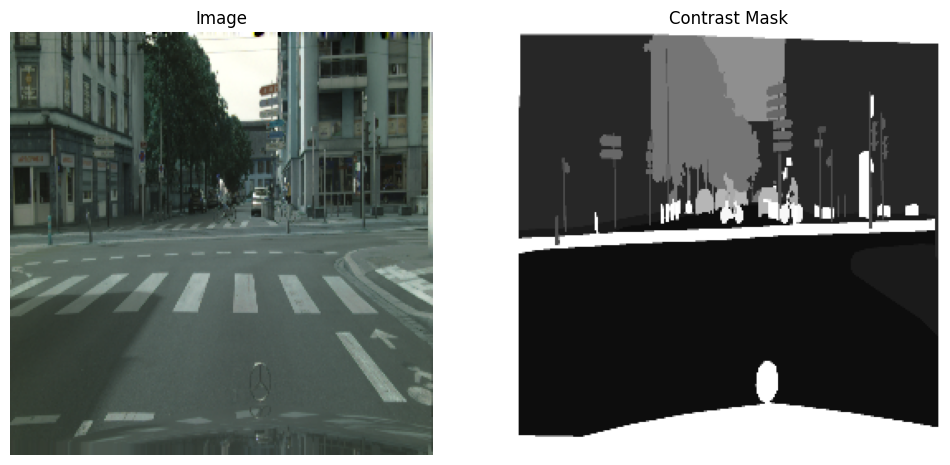

In [67]:
# visualize a sample
def visualize_sample(processed_sample):
    image, mask = processed_sample
    # Convert image from [0, 1] to [0, 255] for display
    image = (image * 255).astype(np.uint8)

    # Create a figure to show image and mask
    plt.figure(figsize=(12, 6))

    # Display the image
    plt.subplot(1, 2, 1)
    plt.imshow(image)
    plt.title('Image')
    plt.axis('off')

    # Display the mask
    plt.subplot(1, 2, 2)
    plt.imshow(mask, cmap='gray')
    plt.title('Contrast Mask')
    plt.axis('off')

    plt.show()

visualize_sample(processed_data[299])

In [68]:
processed_data

[(array([[[0.08627451, 0.15686275, 0.11764706],
          [0.1254902 , 0.16862745, 0.13333333],
          [0.16078431, 0.21960784, 0.19215686],
          ...,
          [0.01176471, 0.02745098, 0.04705882],
          [0.        , 0.        , 0.01176471],
          [0.03921569, 0.05882353, 0.        ]],
  
         [[0.04313725, 0.07843137, 0.0745098 ],
          [0.08235294, 0.12156863, 0.10196078],
          [0.12156863, 0.16470588, 0.15294118],
          ...,
          [0.00392157, 0.02352941, 0.03921569],
          [0.        , 0.        , 0.00784314],
          [0.03921569, 0.05882353, 0.00392157]],
  
         [[0.14901961, 0.21568627, 0.18431373],
          [0.1372549 , 0.18431373, 0.15686275],
          [0.16078431, 0.20784314, 0.2       ],
          ...,
          [0.00392157, 0.02352941, 0.03137255],
          [0.        , 0.        , 0.00784314],
          [0.03921569, 0.05882353, 0.01176471]],
  
         ...,
  
         [[0.28627451, 0.3372549 , 0.29411765],
          [0.2

In [69]:
Val_data_transform = Compose([
    LoadImage(keys=['image', 'mask']),
    Resize(size=(256, 256)),
    Normalize(),
    # ContrastMask(keys='mask')
])

In [70]:
# Preprocess val data
def preprocess_val_data(df):
    processed_val_data = []
    for index, row in df.iterrows():
        sample = {'image': row['image_path'], 'mask': row['image_label_path']}
        transformed_sample = Val_data_transform(sample)
        processed_val_data.append((transformed_sample['image'], transformed_sample['mask']))
    return processed_val_data

In [71]:
# Preprocess validation data
processed_val_data = preprocess_data(val_df_final)
# Example output to verify shapes
print(f"Processed Images: {len(processed_val_data)}")

Processed Images: 380


In [72]:
test_data_transform = Compose([
    LoadImage(keys=['image']),
    Resize(size=(256, 256))
    # Normalize(),
])

In [73]:
# Preprocess testing data
def preprocess_test_data(df):
    processed_test_data = []
    for index, row in df.iterrows():
        sample = {'image': row['image_path']}
        transformed_sample = test_data_transform(sample)
        processed_test_data.append((transformed_sample['image']))
    return processed_test_data

In [74]:
# Preprocess validation data
processed_test_data = preprocess_test_data(test_df)
# Example output to verify shapes
print(f"Processed Images: {len(processed_test_data)}")

Processed Images: 595


In [75]:
processed_data

[(array([[[0.08627451, 0.15686275, 0.11764706],
          [0.1254902 , 0.16862745, 0.13333333],
          [0.16078431, 0.21960784, 0.19215686],
          ...,
          [0.01176471, 0.02745098, 0.04705882],
          [0.        , 0.        , 0.01176471],
          [0.03921569, 0.05882353, 0.        ]],
  
         [[0.04313725, 0.07843137, 0.0745098 ],
          [0.08235294, 0.12156863, 0.10196078],
          [0.12156863, 0.16470588, 0.15294118],
          ...,
          [0.00392157, 0.02352941, 0.03921569],
          [0.        , 0.        , 0.00784314],
          [0.03921569, 0.05882353, 0.00392157]],
  
         [[0.14901961, 0.21568627, 0.18431373],
          [0.1372549 , 0.18431373, 0.15686275],
          [0.16078431, 0.20784314, 0.2       ],
          ...,
          [0.00392157, 0.02352941, 0.03137255],
          [0.        , 0.        , 0.00784314],
          [0.03921569, 0.05882353, 0.01176471]],
  
         ...,
  
         [[0.28627451, 0.3372549 , 0.29411765],
          [0.2

In [76]:
os.makedirs('processed_images', exist_ok=True)
os.makedirs('processed_masks', exist_ok=True)


In [77]:
print(os.listdir('processed_images'))

[]


In [78]:
def save_processed_data(processed_data, output_dir_images, output_dir_masks):
    os.makedirs(output_dir_images, exist_ok=True)
    os.makedirs(output_dir_masks, exist_ok=True)

    for idx, (image, mask) in enumerate(processed_data):
        cv2.imwrite(os.path.join(output_dir_images, f'image_{idx}.png'), image)
        cv2.imwrite(os.path.join(output_dir_masks, f'mask_{idx}.png'), mask)

# Call the function to save images and masks
save_processed_data(processed_data, 'processed_images', 'processed_masks')

In [79]:
os.makedirs('processed_val_images', exist_ok=True)
os.makedirs('processed__val_masks', exist_ok=True)

In [80]:
def save_processed_data(processed_data, output_dir_images, output_dir_masks):
    os.makedirs(output_dir_images, exist_ok=True)
    os.makedirs(output_dir_masks, exist_ok=True)

    for idx, (image, mask) in enumerate(processed_val_data):
        cv2.imwrite(os.path.join(output_dir_images, f'image_{idx}.png'), image)
        cv2.imwrite(os.path.join(output_dir_masks, f'mask_{idx}.png'), mask)

# Call the function to save images and masks
save_processed_data(processed_val_data, 'processed_val_images', 'processed__val_masks')

In [81]:
os.makedirs('processed_test_images', exist_ok=True)

In [82]:
def save_processed_data(processed_data, output_dir_images):
    os.makedirs(output_dir_images, exist_ok=True)

    for idx, (image) in enumerate(processed_test_data):
        cv2.imwrite(os.path.join(output_dir_images, f'image_{idx}.png'), image)

# Call the function to save images and masks
save_processed_data(processed_test_data, 'processed_test_images')